## Multi-fidelity Bayesian Optimization

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

import pandas as pd
import torch

def test_function(input_dict):
    x = input_dict["x"]
    s = input_dict["s"]
    return {"f":np.sin(x + (1.0 - s)) * np.exp((-s+1)/2)}


# define vocs
from xopt import VOCS
vocs = VOCS(
    variables={
        "x": [0, 2*math.pi],
    },
    objectives={"f": "MINIMIZE"},
)

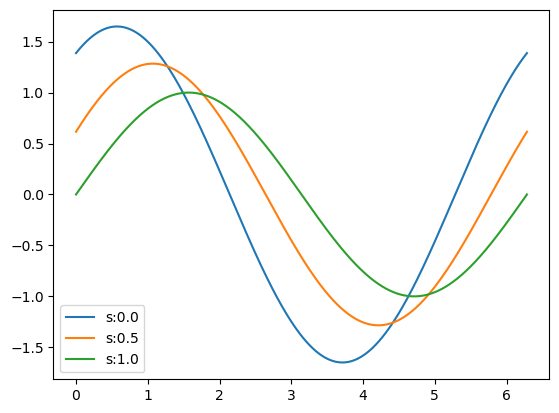

In [2]:
# plot the test function in input + fidelity space
test_x = np.linspace(*vocs.bounds, 1000)
fidelities = [0.0,0.5,1.0]

fig,ax = plt.subplots()
for ele in fidelities:
    f = test_function({"x":test_x, "s":ele})["f"]
    ax.plot(test_x, f,label=f"s:{ele}")

ax.legend()

In [3]:
# create xopt object
from xopt.generators import MultiFidelityBayesianGenerator
from xopt import Evaluator, Xopt

# get and modify default generator options
options = MultiFidelityBayesianGenerator.default_options()

# specify a custom cost function based on the fidelity parameter
options.acq.cost_function = lambda s: s + 0.001

# pass options to the generator
generator = MultiFidelityBayesianGenerator(vocs, options=options)
evaluator = Evaluator(function=test_function)

X = Xopt(vocs=vocs, generator=generator, evaluator=evaluator)
X.generator.options.dict()

{'optim': {'num_restarts': 20,
  'raw_samples': 20,
  'sequential': True,
  'max_travel_distances': None,
  'use_turbo': False},
 'acq': {'proximal_lengthscales': None,
  'use_transformed_proximal_weights': True,
  'monte_carlo_samples': 128,
  'cost_function': <function __main__.<lambda>(s)>,
  'reference_point': None},
 'model': {'name': 'multi_fidelity',
  'custom_constructor': None,
  'use_low_noise_prior': True,
  'covar_modules': {},
  'mean_modules': {},
  'fidelity_parameter': 's'},
 'n_initial': 3,
 'use_cuda': False}

In [4]:
# evaluate initial points at mixed fidelities to seed optimization
X.evaluate_data(pd.DataFrame({
    "x":[math.pi / 4, math.pi / 2., math.pi],"s":[0.0, 0.25, 0.0]
}))

,x,s,f,xopt_runtime,xopt_error
1,0.785398,0.00,1.610902,0.000025,False
2,1.570796,0.25,1.064601,0.000004,False
3,3.141593,0.00,-1.387351,0.000003,False


In [5]:
# get the total cost of previous observations based on the cost function
X.generator.calculate_total_cost()

tensor(0.2530, dtype=torch.float64)

In [6]:
X.generator.reference_point

tensor([-10.,   0.], dtype=torch.float64)

In [7]:
# run optimization until the cost budget is exhausted
# we subtract one unit to make sure we don't go over our eval budget
budget = 4
while X.generator.calculate_total_cost() < budget - 1:
    X.step()
    print(f"budget used: {X.generator.calculate_total_cost()}")


budget used: 0.26707093157971157
budget used: 0.4887721494742319
budget used: 0.8117560274102343
budget used: 1.2512691485651932
budget used: 1.8544751927873317
budget used: 2.682689383928704
budget used: 3.6836893839287037


In [8]:
X.data

,x,s,f,xopt_runtime,xopt_error
1,0.785398,0.000000,1.610902,0.000025,False
2,1.570796,0.250000,1.064601,0.000004,False
3,3.141593,0.000000,-1.387351,0.000003,False
4,6.283185,0.013071,1.366628,0.000009,False
5,3.251891,0.220701,-1.146943,0.000011,False
6,3.004354,0.321984,-0.722554,0.000011,False
7,3.622436,0.438513,-1.143480,0.000010,False
8,4.089846,0.602206,-1.189372,0.000009,False
9,4.144174,0.827214,-1.006102,0.000011,False
10,3.902576,1.000000,-0.689634,0.000010,False


## Plot the model prediction and acquisition function inside the optimization space

torch.Size([2500, 2])


C:\Users\Ryan Roussel\.conda\envs\xopt-dev\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


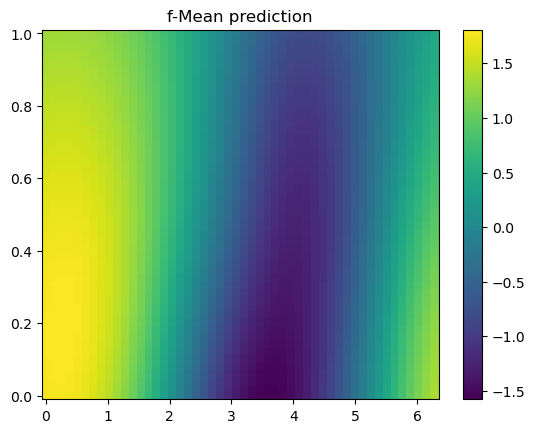

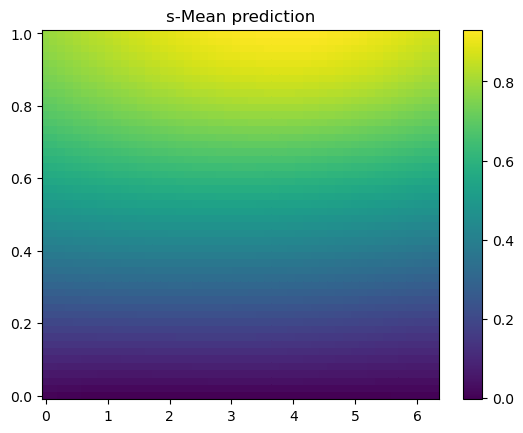

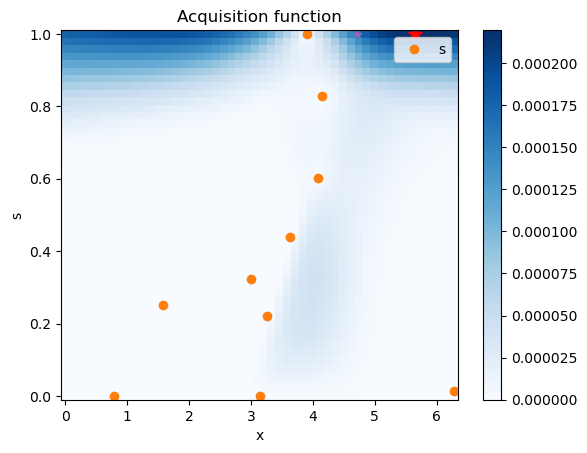

In [9]:
# augment the bounds to add the fidelity parameter
bounds = generator.vocs.bounds
mf_bounds = torch.hstack(
    (torch.tensor(bounds), torch.tensor([0, 1]).reshape(2, 1))
)

model = generator.model

# create mesh
n = 50
x = torch.linspace(*mf_bounds.T[0], n)
y = torch.linspace(*mf_bounds.T[1], n)
xx, yy = torch.meshgrid(x, y)
pts = torch.hstack([ele.reshape(-1, 1) for ele in (xx, yy)]).double()

acq_func = generator.get_acquisition(model)
with torch.no_grad():
    print(pts.shape)
    # get the model posterior
    post = model.posterior(pts.unsqueeze(-2))
    f_mean = post.mean[..., 0]
    s_mean = post.mean[..., 1]


    acq_pts = pts.unsqueeze(1)
    acq = acq_func(acq_pts)

    fig, ax = plt.subplots()
    c = ax.pcolor(xx, yy, f_mean.reshape(n, n))
    fig.colorbar(c)
    ax.set_title("f-Mean prediction")

    fig, ax = plt.subplots()
    c = ax.pcolor(xx, yy, s_mean.reshape(n, n))
    fig.colorbar(c)
    ax.set_title("s-Mean prediction")

    fig, ax = plt.subplots()
    c = ax.pcolor(xx, yy, acq.reshape(n, n), cmap="Blues")
    fig.colorbar(c)
    ax.set_title("Acquisition function")

    X.data.plot(x="x", y="s",ax=ax,style="oC1")
    ax.set_ylabel("s")

    # mark the next observation
    next_pt = pts[torch.argmax(acq)]
    ax.plot(*next_pt,"*r",ms=10)

    # mark the optimum at the max fidelity
    best_loc = [1.5*np.pi, 1.0]
    ax.plot(*best_loc, "*",c="C4")


## Plot the Pareto front

<Axes: xlabel='f'>

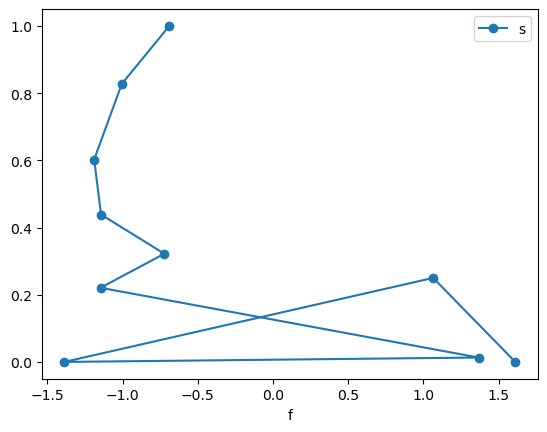

In [10]:
X.data.plot(x="f", y="s", style="o-")

In [11]:
X.data

,x,s,f,xopt_runtime,xopt_error
1,0.785398,0.000000,1.610902,0.000025,False
2,1.570796,0.250000,1.064601,0.000004,False
3,3.141593,0.000000,-1.387351,0.000003,False
4,6.283185,0.013071,1.366628,0.000009,False
5,3.251891,0.220701,-1.146943,0.000011,False
6,3.004354,0.321984,-0.722554,0.000011,False
7,3.622436,0.438513,-1.143480,0.000010,False
8,4.089846,0.602206,-1.189372,0.000009,False
9,4.144174,0.827214,-1.006102,0.000011,False
10,3.902576,1.000000,-0.689634,0.000010,False


In [12]:
# get optimal value at max fidelity
X.generator.get_optimum().to_dict()

{'x': {0: 4.236494673017623}}